In [1]:
import dataloading as dl

In [2]:
from deepforest import utilities
import rasterio as rio
import os 
import glob
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.patches as patches


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
import torchvision
import torchvision.models as models
import torch.nn as nn


import torch.optim as optim
import time
import numpy as np
from sklearn.model_selection import train_test_split
import random
import ast
from comet_ml import Experiment
from sklearn.metrics import confusion_matrix


In [3]:
random_seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#hsi_location_df['taxonID'].unique()

In [5]:
hsi_dir = 'C:/Users/zhou.m/Documents/2023_Fall/NeonTree/weecology/evaluation/Hyperspectral'

In [6]:
hsi_location_df = pd.read_csv('harv_hsi_location.csv', index_col = 0)

hsi_location_df = hsi_location_df[['plotID', 'taxonID', 'pixel_x', 'pixel_y']]
hsi_location_df

,plotID,taxonID,pixel_x,pixel_y
0,HARV_001,QURU,26.0,21.0
1,HARV_001,PIST,23.0,17.0
2,HARV_001,QURU,11.0,18.0
3,HARV_001,PIST,10.0,25.0
4,HARV_001,QURU,18.0,23.0
...,...,...,...,...
619,HARV_052,TSCA,28.0,3.0
620,HARV_052,TSCA,25.0,15.0
621,HARV_052,BEAL2,31.0,11.0
622,HARV_052,BEAL2,37.0,7.0


In [7]:
hsi_location_df['taxonID'].unique()

array(['QURU', 'PIST', 'ACRU', 'BELE', 'ACSA3', 'QUAL', 'FRAM2', 'QUVE',
       'BEPO', 'TSCA', 'PIRI', 'PIAB', 'BEPA', 'PRSE2', 'ACPE', 'BEAL2',
       'NYSY', 'FAGR'], dtype=object)

In [8]:
# Step 1: Get unique values of 'taxonID'
unique_taxonIDs = hsi_location_df['taxonID'].unique()

# Step 2: Map unique values to integers
mapped_ids, mapping_dict = pd.factorize(unique_taxonIDs)

# Step 3: Create a mapping dictionary
taxonID_mapping = dict(zip(unique_taxonIDs, mapped_ids))

# Map the 'taxonID' column to integers and replace the original 'taxonID' column
hsi_location_df['taxonID'] = hsi_location_df['taxonID'].map(taxonID_mapping)

# Print the DataFrame with the replaced column
hsi_location_df

,plotID,taxonID,pixel_x,pixel_y
0,HARV_001,0,26.0,21.0
1,HARV_001,1,23.0,17.0
2,HARV_001,0,11.0,18.0
3,HARV_001,1,10.0,25.0
4,HARV_001,0,18.0,23.0
...,...,...,...,...
619,HARV_052,9,28.0,3.0
620,HARV_052,9,25.0,15.0
621,HARV_052,15,31.0,11.0
622,HARV_052,15,37.0,7.0


In [9]:
np.random.seed(random_seed)

total_samples = len(hsi_location_df)
train_frac = 0.8  # Fraction of data for training, adjust as needed
train_size = int(total_samples * train_frac)

# Generate random indices for training and testing sets
indices = np.random.permutation(total_samples)

# Split the indices into training and testing sets
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Create the training and testing sets
train_set = hsi_location_df.iloc[train_indices]
test_set = hsi_location_df.iloc[test_indices]

train_set


,plotID,taxonID,pixel_x,pixel_y
446,HARV_047,0,18.0,26.0
496,HARV_048,2,0.0,15.0
215,HARV_038,2,31.0,29.0
212,HARV_038,0,13.0,21.0
479,HARV_047,0,8.0,27.0
...,...,...,...,...
514,HARV_049,2,29.0,38.0
519,HARV_049,9,34.0,8.0
584,HARV_051,0,7.0,16.0
221,HARV_038,15,27.0,38.0


C:\Users\zhou.m\AppData\Local\Temp\ipykernel_9168\410911336.py:13: RuntimeWarning: divide by zero encountered in log
  counts_dataframe3 = np.log([np.sum(dataframe3['taxonID'] == label) for label in unique_labels])


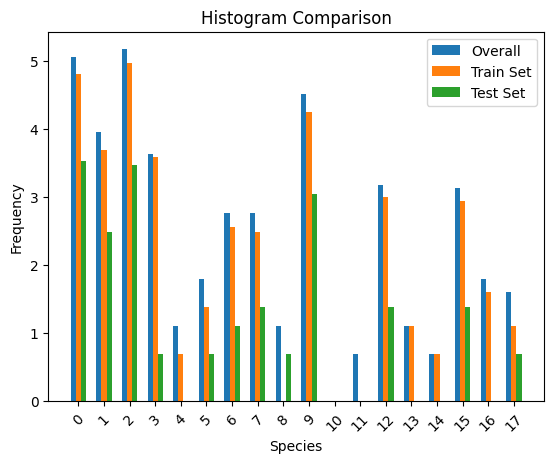

In [10]:
# Sample data in three different dataframes
dataframe1 = hsi_location_df
dataframe2 = train_set
dataframe3 = test_set

# Get unique labels from all dataframes
unique_labels = np.unique(np.concatenate((dataframe1['taxonID'], dataframe2['taxonID'], dataframe3['taxonID'])))
num_labels = len(unique_labels)

# Count occurrences of each label in each dataframe
counts_dataframe1 = np.log([np.sum(dataframe1['taxonID'] == label) for label in unique_labels])
counts_dataframe2 = np.log([np.sum(dataframe2['taxonID'] == label) for label in unique_labels])
counts_dataframe3 = np.log([np.sum(dataframe3['taxonID'] == label) for label in unique_labels])

# Set the positions for the bars
x = np.arange(num_labels)  # X positions for each group of bars
width = 0.2  # Width of each bar

# Plot grouped bar chart
plt.bar(x - width, counts_dataframe1, width, label='Overall')
plt.bar(x, counts_dataframe2, width, label='Train Set')
plt.bar(x + width, counts_dataframe3, width, label='Test Set')

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.title('Histogram Comparison')
plt.xticks(x, unique_labels, rotation = 45)  # Set x-axis labels to unique labels
plt.legend()

# Show the plot
plt.show()

In [11]:
height = 5 # Adjust the size as needed
width = 5

bands_to_use = [i for i in range(369)]  # Adjust the bands to use

# Create the dataset and dataloader
train_dataset = dl.TreeClassification(train_set, hsi_dir, height, width, bands_to_use)
test_dataset = dl.TreeClassification(test_set, hsi_dir, height, width, bands_to_use)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [25]:
height = 7 # Adjust the size as needed
width = 7

bands_to_use = [i for i in range(369)]  # Adjust the bands to use

# Create the dataset and dataloader
train_dataset_7 = dl.TreeClassification(train_set, hsi_dir, height, width, bands_to_use)
test_dataset_7 = dl.TreeClassification(test_set, hsi_dir, height, width, bands_to_use)


train_loader_7 = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader_7 = DataLoader(test_dataset, batch_size=4, shuffle=False)

Text(0.5, 1.0, '2')

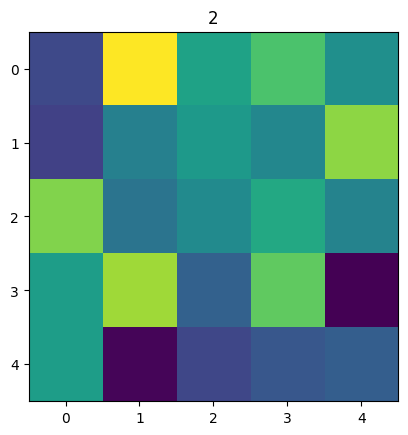

In [12]:
plt.imshow(train_dataset[0][0][:,0,:])
plt.title(train_dataset[1][1])

In [13]:
train_dataset[1][0].shape

torch.Size([5, 369, 5])

In [14]:
model = models.resnet18(pretrained=True)

# Create a new first layer with 369 input channels
new_first_layer = nn.Conv2d(369, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the original first layer with the new one
model.conv1 = new_first_layer

# Adjust the fully connected layer for your classification task
num_classes = len(hsi_location_df['taxonID'].unique())
model.fc = nn.Linear(512, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)

C:\Users\zhou.m\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zhou.m\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Training loop
num_epochs = 100
epoch_loss = []

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.float().to(device), labels.to(device)
        
        inputs = inputs.permute(0, 2, 1, 3)
        #print(inputs.shape)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        # if i % 50 == 0:
        #     print(i)
        
    

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.4f}")
    epoch_loss.append(running_loss / len(train_loader))

torch.save(model.state_dict(), 'trained_classification_model_' + str(num_epochs)+ 'epochs_5kernel.pth')
end_time = time.time()
print(f'Time: {end_time - start_time:.2f} sec')

Epoch [1/100] - Loss: 3.4358
Epoch [2/100] - Loss: 2.9591
Epoch [3/100] - Loss: 3.0468
Epoch [4/100] - Loss: 2.9539
Epoch [5/100] - Loss: 2.8632
Epoch [6/100] - Loss: 2.9432
Epoch [7/100] - Loss: 2.8332
Epoch [8/100] - Loss: 2.7912
Epoch [9/100] - Loss: 2.8704
Epoch [10/100] - Loss: 2.7906
Epoch [11/100] - Loss: 2.8143
Epoch [12/100] - Loss: 2.6737
Epoch [13/100] - Loss: 2.7403
Epoch [14/100] - Loss: 2.7374
Epoch [15/100] - Loss: 2.7739
Epoch [16/100] - Loss: 2.8103
Epoch [17/100] - Loss: 2.7013
Epoch [18/100] - Loss: 2.8610
Epoch [19/100] - Loss: 2.7073
Epoch [20/100] - Loss: 2.7605
Epoch [21/100] - Loss: 2.7274
Epoch [22/100] - Loss: 2.6351
Epoch [23/100] - Loss: 2.7088
Epoch [24/100] - Loss: 2.6134
Epoch [25/100] - Loss: 2.6379
Epoch [26/100] - Loss: 2.6590
Epoch [27/100] - Loss: 2.7337
Epoch [28/100] - Loss: 2.7878
Epoch [29/100] - Loss: 2.5779
Epoch [30/100] - Loss: 2.5721
Epoch [31/100] - Loss: 2.6007
Epoch [32/100] - Loss: 2.6582
Epoch [33/100] - Loss: 2.6808
Epoch [34/100] - Lo